In [1]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
import os
load_dotenv()
llm= ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    groq_api_key=os.getenv("GROQ_API_KEY"))
python_repl_tool = PythonREPLTool()

In [2]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "code_developer"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'code_developer' when code writing, debugging, implementation, computation is necessary, "
                    # "'code_executor' when executing the code, reporting errors and issues is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "code_developer" ]]:

    system_prompt = ('''
                 
                You are a Workflow Supervisor orchestrating a team of two specialized agents: a **Prompt Enhancer** and a **Code Developer**. Your goal is to route the user's request to the most appropriate agent to ensure a smooth, efficient workflow.

**Instructions:**
- You are not given any tools. Just decide which agent to route to next.
- Analyze the user's request and the latest agent response.
- **If the request is ambiguous, vague, or incomplete**, route the task to the **Prompt Enhancer** to clarify and expand it.
- **If the request is clear, precise, and requires code development**, route the task to the **Code Developer**.
- **Always provide a concise rationale for your routing decision.**
    ''')
    
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 
    llm= ChatGroq(
    model="openai/gpt-oss-120b",
    groq_api_key=os.getenv("GROQ_API_KEY"))
    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [3]:
def enhancer(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    system_prompt =( """
    You are a Query Refinement Specialist. Your sole task is to transform ambiguous user requests into a single, clear, and comprehensive instruction for a Code Developer.

**Responsibilities:**
- Analyze the original request for any vagueness, missing details, or assumptions.
- Make reasonable, informed assumptions to fill in any gaps and expand on underdeveloped ideas.
- Restructure the entire request into a single, precise, and actionable paragraph or list.
- **Do not ask questions. Do not provide explanations.**
- **Your entire response must be the final, refined query and nothing else.**
""")
    

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

In [4]:
# Updated code_developer function
def code_developer(state: MessagesState) -> Command[Literal["validator"]]:
    """
    Code developer node that generates and debugs the code based on the query.
    """
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        google_api_key=os.getenv("GEMINI_API_KEY")
    )
    
    system_prompt = """

        You are a highly skilled Frontend Code Developer specializing in HTML, CSS, and JavaScript.
        Your task is to generate clean, functional, and well-structured code based on the user's request.
        
        **Your Responsibilities:**
        1. Analyze the user's request, considering any enhancements or clarifications.
        2. Generate all necessary code (HTML, CSS, and JavaScript) to fulfill the request.
        3. Ensure the code is production-ready, well-formatted, and adheres to best practices.
        4. Provide the complete code for all three languages in a single, well-organized response.
        5. Do not include any text or explanations outside of the code blocks. Your entire response must be the code itself.
        Provide the complete code for HTML, CSS, and JavaScript in that specific order, ensuring each block is present and well-formatted
        
        **Example Output Format:**
        
        ```html
        <!DOCTYPE html>
        <html>
        ...
        </html>
        ```
        
        ```css
        /* CSS styles here */
        body {
          ...
        }
        ```

        ```javascript
        // JavaScript code here
        document.addEventListener('DOMContentLoaded', () => {
          ...
        });
        ```
        """
        
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    result = llm.invoke(messages)
    generated_content = result.content
    
    print("--- Workflow Transition: Code Developer → Validator ---")
    
    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=generated_content,
                    name="code_developer"
                )
            ]
        },
        goto="validator", 
    )

In [5]:
import re
from IPython.display import HTML, display
import time
class ValidatorLLM(BaseModel):
    next: Literal["supervisor", "__end__"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or '__end__' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def parse_code(content: str):
    """Parses HTML, CSS, and JS from code blocks using a more flexible regex."""
    html_code = ""
    css_code = ""
    js_code = ""

    # Updated regex to be more flexible with whitespace and newlines
    html_match = re.search(r"```html\s*([\s\S]*?)\s*```", content)
    if html_match:
        html_code = html_match.group(1).strip()
    
    css_match = re.search(r"```css\s*([\s\S]*?)\s*```", content)
    if css_match:
        css_code = css_match.group(1).strip()

    js_match = re.search(r"```javascript\s*([\s\S]*?)\s*```", content)
    if js_match:
        js_code = js_match.group(1).strip()

    return html_code, css_code, js_code

def create_project_from_output(agent_output_content: str, folder_name: str = "project"):
    """
    Parses agent output and creates a folder containing index.html, style.css, and script.js.

    Args:
        agent_output_content (str): The string content from the agent's final output.
        folder_name (str): The name of the folder to create.
    """
    html_code, css_code, js_code = parse_code(agent_output_content)

    if not html_code and not css_code and not js_code:
        print("Error: No valid code blocks found in the agent's output. Files not created.")
        return

    try:
        os.makedirs(folder_name, exist_ok=True)
        print(f"Directory '{folder_name}' created or already exists.")
    except OSError as e:
        print(f"Error creating directory: {e}")
        return

    file_contents = {
        "index.html": html_code,
        "style.css": css_code,
        "script.js": js_code
    }

    for file_name, content in file_contents.items():
        file_path = os.path.join(folder_name, file_name)
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(content)
            print(f"File '{file_path}' created successfully.")

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Validates and previews the generated frontend code, then determines the next step.
    """
    # Replace with your actual LLM setup
    from langchain_google_genai import ChatGoogleGenerativeAI 
    import os
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", 
        google_api_key=os.getenv("GEMINI_API_KEY")
    )
    
    last_message = state["messages"][-1]
    generated_code = last_message.content
    
    html_code, css_code, js_code = parse_code(generated_code)
    
    full_html = f"""
    <style>
    {css_code}
    </style>
    {html_code}
    <script>
    {js_code}
    </script>
    """
    print("--- Frontend Preview ---")
    display(HTML(full_html))
    print("------------------------")
    
    system_prompt = '''
    Your task is to ensure the generated code is relevant to the user's initial question.
    - Review the user's original request.
    - Review the generated code.
    - If the code is completely off-topic, harmful, or fundamentally misunderstands the request, route to 'supervisor'.
    - Otherwise, route to '__end__'.
    - Accept code that is "good enough" rather than perfect, focusing on relevance.
    '''
    
    user_question = state["messages"][0].content
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": generated_code},
    ]

    llm_response = llm.with_structured_output(ValidatorLLM).invoke(messages)
    
    goto = llm_response.next
    reason = llm_response.reason
    
    print(f"LLM Validation: {reason}")
    
    if goto == "supervisor":
        print("--- LLM Validation failed. Routing back to Supervisor for review. ---")
        return Command(
            update={"messages": [HumanMessage(content=f"LLM validation failed: {reason}", name="validator")]},
            goto="supervisor"
        )
    
    print("--- LLM Validation successful, awaiting human feedback. ---")
    user_feedback = input("Please provide feedback or type 'ok' to approve: ").strip().lower()
    
    if user_feedback in ["ok", "ok.", "yes", "looks good"]:
        print("Human approval granted. Workflow transitioning to END.")
        
        final_code_output = f"""
        Final Code Approved!
        Here is the complete and final code for your frontend:
        ```html
        {html_code}
        ```
        ```css
        {css_code}
        ```
        ```javascript
        {js_code}
        ```
        """
        
        # 📂 This is where you call the function to create the folder and files!
        # create_project_from_output(final_code_output, folder_name="profile_card_project")
        prompt_words = user_question.lower().split()[:5]
        sanitized_words = [re.sub(r'[^a-z0-9]', '', word) for word in prompt_words]
        project_name = '_'.join(sanitized_words)
        
        # Add a timestamp to ensure uniqueness
        timestamp = int(time.time())
        dynamic_folder_name = f"{project_name}_{timestamp}"
        
        # Call the function with the dynamic name
        create_project_from_output(final_code_output, folder_name=dynamic_folder_name)
        
        return Command(
            update={"messages": [HumanMessage(content=final_code_output, name="final_agent")]},
            goto=END
        )
    else:
        print("User requested changes. Routing back to supervisor.")
        final_goto = "supervisor"
        feedback_message = f"The user provided the following feedback: '{user_feedback}'. The code needs to be updated to address this."
        
        return Command(
            update={"messages": [HumanMessage(content=feedback_message, name="validator")]},
            goto=final_goto
        )

In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect(database='chatbot.db', check_same_thread=False)
# Checkpointer
checkpointer = SqliteSaver(conn=conn)

In [7]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer)  

graph.add_node("code_developer", code_developer) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile(checkpointer=checkpointer)

In [8]:
# thread_id = "my_design_project_1"
# config = {"configurable": {"thread_id": thread_id}}

# print(f"Starting or resuming project with ID: {thread_id}")

In [9]:
# user_input = "Create a dark-themed profile card with social icons."

# # Invoke the agent
# output = app.invoke({"messages": [("user", user_input)]}, config=config)

In [10]:
# user_feedback = "Add a button and the button color should be yellow when clicked and show an alert with the user's email address 'abc@gmil.com'"

# # Invoke the agent again
# output = app.invoke({"messages": [("user", user_feedback)]}, config=config)

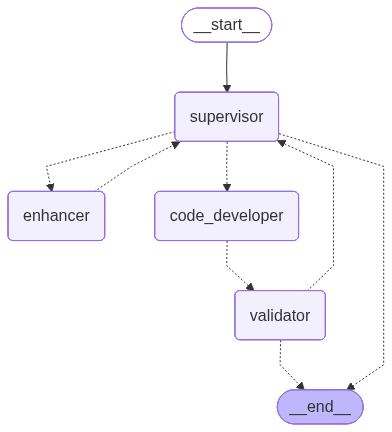

In [11]:
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 
# 

In [12]:
import pprint
thread_id = "my_design_project_3"
config1 = {"configurable": {"thread_id": thread_id}}
inputs ={
    "messages": [
        ("user", " make a tic tac toe game "),
    ]
    
}

for event in app.stream(inputs,config=config1):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → CODE_DEVELOPER ---
"Output from node 'supervisor':"
HumanMessage(content='The user request is clear and specifies creating a tic-tac-toe game, which requires code implementation. No clarification is needed, so the task should be routed to the Code Developer.', additional_kwargs={}, response_metadata={}, name='supervisor', id='cbbb65e0-b949-4b0a-8bd4-c895bfbb51b5')

--- Workflow Transition: Code Developer → Validator ---
"Output from node 'code_developer':"
HumanMessage(content='```html\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>Tic Tac Toe</title>\n    <link rel="stylesheet" href="style.css">\n</head>\n<body>\n    <div class="game-container">\n        <h1>Tic Tac Toe</h1>\n        <div id="game-status" class="game-status"></div>\n        <div class="game-board" id="game-board">\n            <div class="cell" data-cell-index="0"></div>

------------------------
LLM Validation: The user asked for a Tic Tac Toe game, and the generated code provides HTML, CSS, and JavaScript files to create a functional Tic Tac Toe game. This directly addresses the user's request.
--- LLM Validation successful, awaiting human feedback. ---
Human approval granted. Workflow transitioning to END.
Directory 'make_a_tic_tac_toe_1757685225' created or already exists.
File 'make_a_tic_tac_toe_1757685225\index.html' created successfully.
File 'make_a_tic_tac_toe_1757685225\style.css' created successfully.
File 'make_a_tic_tac_toe_1757685225\script.js' created successfully.
"Output from node 'validator':"
HumanMessage(content='\n        Final Code Approved!\n        Here is the complete and final code for your frontend:\n        ```html\n        <!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>Tic Tac Toe</title>\n    <link rel="stylesheet

In [13]:
# hghghghg

In [14]:
# llama-3.3-70b-versatile

In [15]:
'''        You are a highly skilled Frontend Code Developer specializing in HTML, CSS, and JavaScript.
        Your task is to generate clean, functional, and well-structured code based on the user's request.
        
        **Your Responsibilities:**
        1. Analyze the user's request, considering any enhancements or clarifications.
        2. Generate all necessary code (HTML, CSS, and JavaScript) to fulfill the request.
        3. Ensure the code is production-ready, well-formatted, and adheres to best practices.
        4. Provide the complete code for all three languages in a single, well-organized response.
        5. Do not include any text or explanations outside of the code blocks. Your entire response must be the code itself.
        Provide the complete code for HTML, CSS, and JavaScript in that specific order, ensuring each block is present and well-formatted
        '''

"        You are a highly skilled Frontend Code Developer specializing in HTML, CSS, and JavaScript.\n        Your task is to generate clean, functional, and well-structured code based on the user's request.\n\n        **Your Responsibilities:**\n        1. Analyze the user's request, considering any enhancements or clarifications.\n        2. Generate all necessary code (HTML, CSS, and JavaScript) to fulfill the request.\n        3. Ensure the code is production-ready, well-formatted, and adheres to best practices.\n        4. Provide the complete code for all three languages in a single, well-organized response.\n        5. Do not include any text or explanations outside of the code blocks. Your entire response must be the code itself.\n        Provide the complete code for HTML, CSS, and JavaScript in that specific order, ensuring each block is present and well-formatted\n        "

In [16]:
"""You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n
        1. Analyzing the original query to identify key intent and requirements\n
        2. Resolving any ambiguities without requesting additional user input\n
        3. Expanding underdeveloped aspects of the query with reasonable assumptions\n
        4. Restructuring the query for clarity and actionability\n
        5. Ensuring all technical terminology is properly defined in context\n\n
        Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible.
 """

'You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n\n        1. Analyzing the original query to identify key intent and requirements\n\n        2. Resolving any ambiguities without requesting additional user input\n\n        3. Expanding underdeveloped aspects of the query with reasonable assumptions\n\n        4. Restructuring the query for clarity and actionability\n\n        5. Ensuring all technical terminology is properly defined in context\n\n\n        Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible.\n '

In [17]:
''' You are a workflow supervisor managing a team of 2 specialized agents: Prompt Enhancer and Code developer. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Code developer**: Specializes in code development , solutions and  error resolving and debugging needed to address the user's request.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
        '''

" You are a workflow supervisor managing a team of 2 specialized agents: Prompt Enhancer and Code developer. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.\n\n        **Team Members**:\n        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.\n        2. **Code developer**: Specializes in code development , solutions and  error resolving and debugging needed to address the user's request.\n\n        **Your Responsibilities**:\n        1. Analyze each user request and agent response for completeness, accuracy, and relevance.\n        2. Route the task to the most appropriate agent at each decision point.\n        3. Maintain workflow momentum by avo